In [112]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [113]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.columns = df.columns.str.strip()

In [114]:
macro = 'IM'
df = df[[macro, 'Bitcoin']].dropna().copy()
df['Bitcoin_vol_lag1'] = df['Bitcoin'].shift(1)
df = df.dropna()  # Drop NaN from lag

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86639D+00    |proj g|=  4.58110D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     14      1     0     0   4.581D-03   5.866D+00
  F =   5.8663925363775293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.0

/Users/anniewang/opt/anaconda3/envs/py39env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


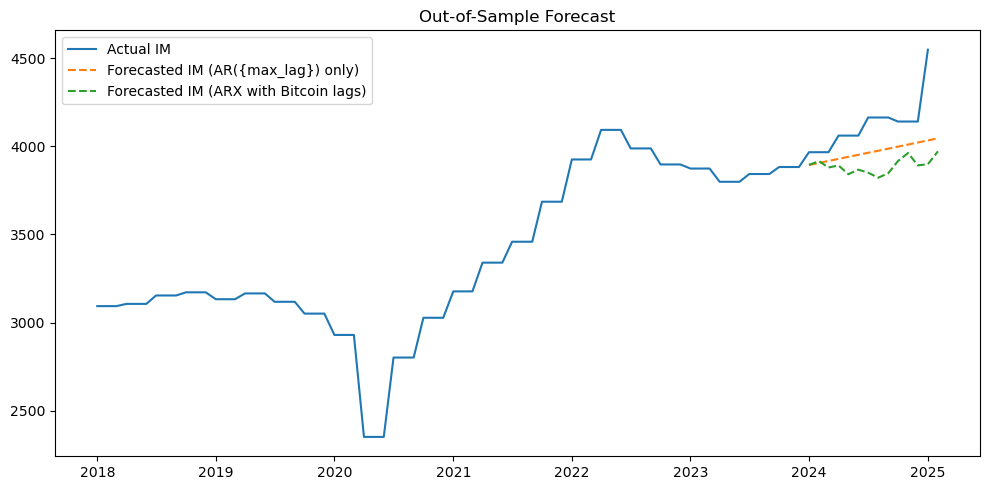

In [115]:
max_lag = 3

# Create lagged Bitcoin volatility columns
for lag in range(1, max_lag + 1):
    df[f'Bitcoin_vol_lag{lag}'] = df['Bitcoin'].shift(lag)

# Drop NaNs created by lagging
df = df.dropna().copy()

# Separate endogenous and exogenous variables
endog = df[macro]
exog = df[[f'Bitcoin_vol_lag{lag}' for lag in range(1, max_lag + 1)]]

# Train/test split
train_end = '2023-12-01'
train_endog = endog[:train_end]
train_exog = exog[:train_end]

test_endog = endog[train_end:]
test_exog = exog[train_end:]

# 1. AR model (GDP only), with AR order = max_lag
model_macro = SARIMAX(train_endog,
                    order=(max_lag, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
result_macro = model_macro.fit()

# 2. ARX model (GDP + lagged Bitcoin volatility)
model_withCryp = SARIMAX(train_endog,
                         exog=train_exog,
                         order=(max_lag, 0, 0),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_withCryp = model_withCryp.fit()

# Forecast
forecast_1 = result_macro.get_forecast(steps=len(test_endog))
forecast_2 = results_withCryp.get_forecast(steps=len(test_endog), exog=test_exog)

predicted_mean1 = forecast_1.predicted_mean
predicted_mean2 = forecast_2.predicted_mean

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(endog, label='Actual ' + macro)
plt.plot(predicted_mean1, label=f'Forecasted ' + macro+ ' (AR({max_lag}) only)', linestyle='--')
plt.plot(predicted_mean2, label=f'Forecasted ' + macro+ ' (ARX with Bitcoin lags)', linestyle='--')
plt.title("Out-of-Sample Forecast")
plt.legend()
plt.tight_layout()
plt.show()